# Download Dataset

In [ ]:
!pip install -q kaggle

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets list

ref                                                         title                                              size  lastUpdated          downloadCount  
----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
gpreda/reddit-vaccine-myths                                 Reddit Vaccine Myths                              233KB  2021-08-15 09:48:42          10724  
crowww/a-large-scale-fish-dataset                           A Large Scale Fish Dataset                          3GB  2021-04-28 17:03:01           6544  
imsparsh/musicnet-dataset                                   MusicNet Dataset                                   22GB  2021-02-18 14:12:19           2470  
dhruvildave/wikibooks-dataset                               Wikibooks Dataset                                   2GB  2021-07-03 18:37:20           2654  
promptcloud/careerbuilder-job-listing-2020                  Careerbuilder Jo

In [ ]:
!kaggle datasets download 'ashishjangra27/gender-recognition-200k-images-celeba'

100% 1.31G/1.32G [00:13<00:00, 135MB/s]
100% 1.32G/1.32G [00:13<00:00, 108MB/s]


In [ ]:
!unzip -q gender-recognition-200k-images-celeba.zip

In [ ]:
!mkdir Dataset_small
!mkdir Dataset_small/Train
!mkdir Dataset_small/Train/Male
!mkdir Dataset_small/Train/Female
!mkdir Dataset_small/Validation
!mkdir Dataset_small/Validation/Male
!mkdir Dataset_small/Validation/Female

In [ ]:
import os
import shutil
import random

In [ ]:
base_path = 'Dataset'
dest_path = 'Dataset_small'
subsets = ['Train', 'Validation']
classes = ['Male', 'Female']

for subset in subsets:
    for cls in classes:
        files = os.listdir(os.path.join(base_path, subset, cls))
        random.shuffle(files)

        split = int(0.05 * len(files))

        for dir in files[:split]:
            shutil.copyfile(
                os.path.join(base_path, subset, cls, dir),
                os.path.join(dest_path, subset, cls, dir)
                )

# imports

In [ ]:
import numpy as np
import tensorflow
import tensorflow.keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalMaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tqdm import tqdm
import matplotlib.pyplot as plt

# Extracting features and then training a classifier

## Feature Extraction

In [ ]:
datagen = ImageDataGenerator(rescale=1./255 ,preprocessing_function=preprocess_input)

train_datagen = datagen.flow_from_directory('Dataset_small/Train',
                                            batch_size=32,
                                            shuffle=True,
                                            target_size=(224, 224),
                                            class_mode='binary')

val_datagen = datagen.flow_from_directory('Dataset_small/Validation',
                                            batch_size=32,
                                            shuffle=True,
                                            target_size=(224, 224),
                                            class_mode='binary')

Found 7999 images belonging to 2 classes.
Found 1129 images belonging to 2 classes.


In [ ]:
print(int(7999 / 32) * 32)
print(int(1129 / 32) * 32)

7968
1120


In [ ]:
model = VGG16(weights='imagenet', include_top=False)

inp = Input(shape=(224, 224, 3), batch_size=32)

x = model(inp)
x = GlobalMaxPooling2D()(x)

model_feature_extractor = Model(inputs=[inp], outputs=[x])

58892288/58889256 [==============================] - 0s 0us/step


In [ ]:
X_train = np.zeros((7968, 512), dtype=np.float32)
y_train = np.zeros((7968))

X_val = np.zeros((1120, 512), dtype=np.float32)
y_val = np.zeros((1120))

In [ ]:
i = 0
while i < X_train.shape[0]:
    btch = train_datagen.next()
    if i + btch[0].shape[0] >  X_train.shape[0]:
        btch = (btch[0][:X_train.shape[0] - i], btch[1][:X_train.shape[0] - i])
    X_train[i:i+btch[0].shape[0]] = model_feature_extractor.predict(btch[0])
    y_train[i:i+btch[0].shape[0]] = btch[1]

    i += btch[0].shape[0]


i = 0
while i < X_val.shape[0]:
    btch = val_datagen.next()
    if i + btch[0].shape[0] >  X_val.shape[0]:
        btch[0] = (btch[0][:X_val.shape[0] - i], btch[1][:X_val.shape[0] - i])
    X_val[i:i+btch[0].shape[0]] = model_feature_extractor.predict(btch[0])
    y_val[i:i+btch[0].shape[0]] = btch[1]

    i += btch[0].shape[0]

In [ ]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(7968, 512) (7968,)
(1120, 512) (1120,)


## Training classifiers

In [ ]:
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential

In [ ]:
# del clf_model

clf_model =  Sequential()

clf_model.add(Dense(128, activation='relu', input_dim=512))
clf_model.add(Dropout(0.3))
clf_model.add(Dense(1, activation='sigmoid'))

clf_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [ ]:
res = clf_model.fit(X_train, y_train.reshape(-1, 1), epochs=50, batch_size=32,
              validation_data=(X_val, y_val.reshape(-1, 1)))

Epoch 1/50
249/249 [==============================] - 1s 3ms/step - loss: 0.3880 - acc: 0.8279 - val_loss: 0.2416 - val_acc: 0.8991
Epoch 2/50
249/249 [==============================] - 1s 3ms/step - loss: 0.2578 - acc: 0.8896 - val_loss: 0.2087 - val_acc: 0.9098
Epoch 3/50
249/249 [==============================] - 1s 2ms/step - loss: 0.2339 - acc: 0.9014 - val_loss: 0.2099 - val_acc: 0.9036
Epoch 4/50
249/249 [==============================] - 1s 2ms/step - loss: 0.2222 - acc: 0.9037 - val_loss: 0.2013 - val_acc: 0.9107
Epoch 5/50
249/249 [==============================] - 1s 2ms/step - loss: 0.2147 - acc: 0.9123 - val_loss: 0.2181 - val_acc: 0.9054
Epoch 6/50
249/249 [==============================] - 1s 2ms/step - loss: 0.2076 - acc: 0.9148 - val_loss: 0.2076 - val_acc: 0.9045
Epoch 7/50
249/249 [==============================] - 1s 2ms/step - loss: 0.1981 - acc: 0.9168 - val_loss: 0.1991 - val_acc: 0.9125
Epoch 8/50
249/249 [==============================] - 1s 2ms/step - loss: 0.

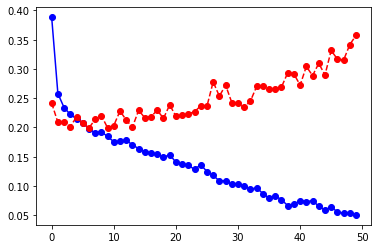

In [ ]:
plt.plot(res.history['loss'], 'b-o')
plt.plot(res.history['val_loss'], 'r--o')

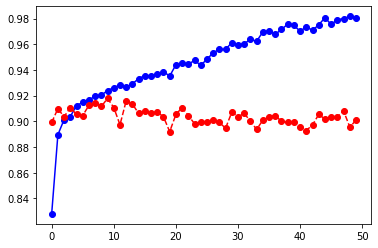

In [ ]:
plt.plot(res.history['acc'], 'b-o')
plt.plot(res.history['val_acc'], 'r--o')

# Adding classifier to model and training classifier

## DataGenerators

In [ ]:
datagen = ImageDataGenerator(rescale=1./255, preprocessing_function=preprocess_input)

train_datagen = datagen.flow_from_directory('Dataset_small/Train',
                                            batch_size=32,
                                            shuffle=True,
                                            target_size=(224, 224),
                                            class_mode='binary')

val_datagen = datagen.flow_from_directory('Dataset_small/Validation',
                                            batch_size=32,
                                            shuffle=True,
                                            target_size=(224, 224),
                                            class_mode='binary')

Found 7999 images belonging to 2 classes.
Found 1129 images belonging to 2 classes.


In [ ]:
print(7999 / 32)
print(1129 / 32)

249.96875
35.28125


## Model

In [ ]:
CNN_model = VGG16(weights='imagenet', include_top=False)

inp = Input(shape=(224, 224, 3))

x = CNN_model(inp)
x = GlobalMaxPooling2D()(x)

x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(1, activation='sigmoid')(x)

full_model = Model(inputs=[inp], outputs=[x])

In [ ]:
full_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
CNN_model.trainable = False

In [ ]:
full_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, None, None, 512)   14714688  
_________________________________________________________________
global_max_pooling2d_2 (Glob (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 129       
Total params: 14,780,481
Trainable params: 65,793
Non-trainable params: 14,714,688
__________________________________________

## Training classifiers

In [ ]:
res = full_model.fit(train_datagen, steps_per_epoch=250, epochs=20, 
                         validation_data=val_datagen, validation_steps=35)

Epoch 1/20
250/250 [==============================] - 100s 396ms/step - loss: 0.7200 - acc: 0.5526 - val_loss: 0.6729 - val_acc: 0.6098
Epoch 2/20
250/250 [==============================] - 101s 405ms/step - loss: 0.6371 - acc: 0.6426 - val_loss: 0.5232 - val_acc: 0.7366
Epoch 3/20
250/250 [==============================] - 101s 405ms/step - loss: 0.5239 - acc: 0.7496 - val_loss: 0.4686 - val_acc: 0.7750
Epoch 4/20
250/250 [==============================] - 101s 404ms/step - loss: 0.4785 - acc: 0.7787 - val_loss: 0.4430 - val_acc: 0.8045
Epoch 5/20
250/250 [==============================] - 101s 404ms/step - loss: 0.3900 - acc: 0.8261 - val_loss: 0.2371 - val_acc: 0.9054
Epoch 6/20
250/250 [==============================] - 101s 404ms/step - loss: 0.2649 - acc: 0.8872 - val_loss: 0.3118 - val_acc: 0.8625
Epoch 7/20
250/250 [==============================] - 101s 402ms/step - loss: 0.2288 - acc: 0.9064 - val_loss: 0.1860 - val_acc: 0.9223
Epoch 8/20
250/250 [============================

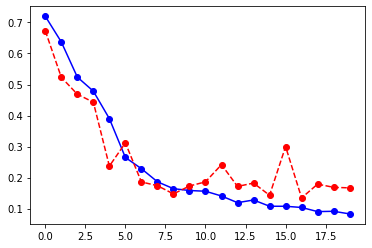

In [ ]:
plt.plot(res.history['loss'], 'b-o')
plt.plot(res.history['val_loss'], 'r--o')

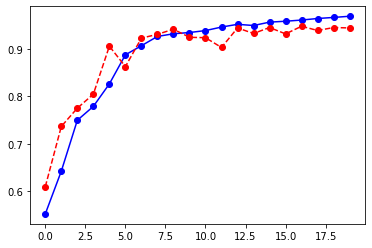

In [ ]:
plt.plot(res.history['acc'], 'b-o')
plt.plot(res.history['val_acc'], 'r--o')

In [ ]:
CNN_model.trainable = True

In [ ]:
full_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, None, None, 512)   14714688  
_________________________________________________________________
global_max_pooling2d_2 (Glob (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 129       
Total params: 14,780,481
Trainable params: 14,780,481
Non-trainable params: 0
_______________________________________________

In [ ]:
res_finetuning = full_model.fit(train_datagen, steps_per_epoch=250, epochs=20, 
                         validation_data=val_datagen, validation_steps=35)

Epoch 1/20
250/250 [==============================] - 99s 397ms/step - loss: 0.0814 - acc: 0.9684 - val_loss: 0.2012 - val_acc: 0.9357
Epoch 2/20
250/250 [==============================] - 101s 404ms/step - loss: 0.0733 - acc: 0.9716 - val_loss: 0.1738 - val_acc: 0.9482
Epoch 3/20
250/250 [==============================] - 101s 403ms/step - loss: 0.0673 - acc: 0.9734 - val_loss: 0.2077 - val_acc: 0.9259
Epoch 4/20
250/250 [==============================] - 101s 404ms/step - loss: 0.0668 - acc: 0.9757 - val_loss: 0.1720 - val_acc: 0.9500
Epoch 5/20
250/250 [==============================] - 101s 403ms/step - loss: 0.0714 - acc: 0.9709 - val_loss: 0.1546 - val_acc: 0.9455
Epoch 6/20
250/250 [==============================] - 101s 403ms/step - loss: 0.0851 - acc: 0.9667 - val_loss: 0.1619 - val_acc: 0.9563
Epoch 7/20
250/250 [==============================] - 101s 403ms/step - loss: 0.0632 - acc: 0.9746 - val_loss: 0.1678 - val_acc: 0.9580
Epoch 8/20
250/250 [=============================

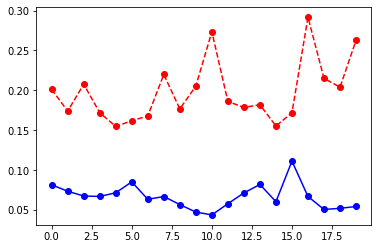

In [ ]:
plt.plot(res_finetuning.history['loss'], 'b-o')
plt.plot(res_finetuning.history['val_loss'], 'r--o')

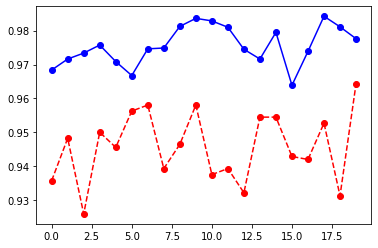

In [ ]:
plt.plot(res_finetuning.history['acc'], 'b-o')
plt.plot(res_finetuning.history['val_acc'], 'r--o')

In [ ]:
loss = np.hstack((res.history['loss'], res_finetuning.history['loss']))
val_loss = np.hstack((res.history['val_loss'], res_finetuning.history['val_loss']))
acc = np.hstack((res.history['acc'], res_finetuning.history['acc']))
val_acc = np.hstack((res.history['val_acc'], res_finetuning.history['val_acc']))

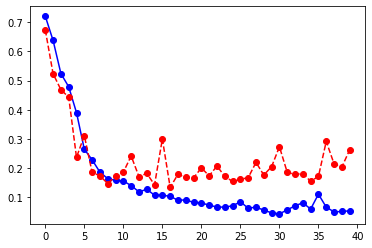

In [ ]:
plt.plot(loss, 'b-o')
plt.plot(val_loss, 'r--o')

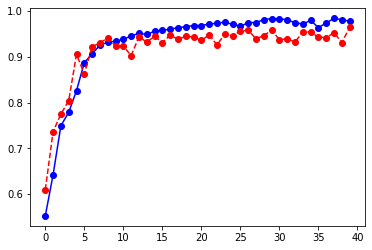

In [ ]:
plt.plot(acc, 'b-o')
plt.plot(val_acc, 'r--o')